In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import (adjusted_rand_score, adjusted_mutual_info_score,
                           homogeneity_score, completeness_score, v_measure_score,
                           fowlkes_mallows_score, classification_report)
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

# 🧬 В качестве датасета было взято исследование клеточных линий NCI-60

**📊 Статус:** Public on Sep 29, 2011

## 🔍 Детали исследования

- **Название:** Comparison between cell lines from 9 different cancer tissue (NCI-60) (Affymetrix U133 Plus 2.0)
- **Организм:** *Homo sapiens*
- **Тип эксперимента:** Expression profiling by array
- **Ссылка:** https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE32474

## 📝 Описание

**Краткое содержание:** Comparison between cell lines from 9 different cancer tissue of origin types (Breast, Central Nervous System, Colon, Leukemia, Melanoma, Non-Small Cell Lung, Ovarian, Prostate, Renal) from NCI-60 panel.

**Общий дизайн:** Cell lines from 9 different cancer tissue of origin types

In [2]:
data = pd.read_csv('GSE32474_series_matrix.txt', sep='\t', comment='!', header=0, index_col=0)

In [3]:
data.head()

GSM803615  GSM803616  GSM803617  GSM803618  GSM803619  GSM803620  \
ID_REF                                                                        
1007_s_at   7.985880   6.814140   8.300014   7.671698   7.099600   8.830645   
1053_at     8.912589   8.687835   8.481438   8.061294   8.289561   9.155453   
117_at      5.958179   4.962832   4.669642   4.770958   4.766327   6.265924   
121_at      7.256472   7.230669   7.601425   7.725125   7.781456   7.507420   
1255_g_at   2.702940   2.793792   3.098890   2.613745   2.732826   2.745017   

           GSM803621  GSM803622  GSM803623  GSM803624  ...  GSM803779  \
ID_REF                                                 ...              
1007_s_at   7.846669   8.905437  11.697271   8.757207  ...  10.005175   
1053_at     8.522158   7.128201   8.031576   8.235230  ...   7.800537   
117_at      4.605385   5.081578   5.023916   7.574211  ...   5.014771   
121_at      7.592139   7.382917   7.618726   7.699955  ...   7.279489   
1255_g_at   2.490546   2.549441   2.732843   2.699394  ...   2.625860   

           GSM803780  GSM803781  GSM803782  GSM803783  GSM803784  GSM803785  \
ID_REF                                                                        
1007_s_at   9.002985   8.897803   8.909760   9.947224   9.367096   8.761576   
1053_at     6.606172   7.890228   9.148736   9.351174   9.248582   9.011086   
117_at      6.670192   4.817486   4.990727   5.712095   5.409390   5.328212   
121_at      7.566904   7.335448   7.258489   7.678649   7.321783   7.446752   
1255_g_at   2.521844   2.819514   2.857415   2.782202   2.667896   2.910594   

           GSM803786  GSM803787  GSM803788  
ID_REF                                      
1007_s_at   9.023015   6.905313  10.959925  
1053_at     7.786519   8.203525   7.795438  
117_at      4.896985   5.189779   4.977684  
121_at      7.232856   7.236290   7.458360  
1255_g_at   2.689686   2.745957   2.572363  

[5 rows x 174 columns]

## 🧬 Структура данных экспрессии генов

### 📊 Столбцы (Образцы)
- GSM803615, GSM803616, ... - идентификаторы образцов в базе GEO
- Каждый столбец представляет одну клеточную линию из панели NCI-60
- Всего: 60+ образцов различных типов рака

### 🧫 Строки (Гены)
- ID_REF - идентификаторы генов на микрочипе
- 1007_s_at, 1063_at, 117_at, ... - названия проб на платформе Affymetrix U133 Plus 2.0
- Каждая строка представляет уровень экспрессии одного гена во всех образцах

**Следовательно, истинной матрицей объект-признак является транспонированный датасет**

In [4]:
data = data.T
data.head()

ID_REF     1007_s_at   1053_at    117_at    121_at  1255_g_at   1294_at  \
GSM803615   7.985880  8.912589  5.958179  7.256472   2.702940  7.310829   
GSM803616   6.814140  8.687835  4.962832  7.230669   2.793792  6.903610   
GSM803617   8.300014  8.481438  4.669642  7.601425   3.098890  7.131628   
GSM803618   7.671698  8.061294  4.770958  7.725125   2.613745  6.803858   
GSM803619   7.099600  8.289561  4.766327  7.781456   2.732826  7.686407   

ID_REF      1316_at   1320_at  1405_i_at   1431_at  ...  AFFX-r2-Ec-bioD-3_at  \
GSM803615  4.930408  4.501004   2.798745  4.594578  ...              2.450764   
GSM803616  4.897825  4.546514   7.997320  3.838856  ...              2.484282   
GSM803617  5.027698  4.630086   2.980830  3.507437  ...              2.822748   
GSM803618  5.122255  4.640928   7.931418  3.293151  ...              2.643111   
GSM803619  5.072995  5.238705   2.806849  3.214408  ...              2.537910   

ID_REF     AFFX-r2-Ec-bioD-5_at  AFFX-r2-P1-cre-3_at  AFFX-r2-P1-cre-5_at  \
GSM803615              3.533234             2.749541             3.159154   
GSM803616              3.598432             2.902598             3.138456   
GSM803617              3.439777             3.078307             2.903898   
GSM803618              3.525568             2.763061             2.762084   
GSM803619              3.423929             2.674596             3.135389   

ID_REF     AFFX-ThrX-3_at  AFFX-ThrX-5_at  AFFX-ThrX-M_at  AFFX-TrpnX-3_at  \
GSM803615        3.622184        3.363546        2.673239         2.728595   
GSM803616        3.913335        3.149862        3.164152         2.780677   
GSM803617        3.859732        3.575853        2.836154         2.626707   
GSM803618        3.613617        3.344044        2.963669         2.914559   
GSM803619        3.856040        3.530103        2.872226         2.900679   

ID_REF     AFFX-TrpnX-5_at  AFFX-TrpnX-M_at  
GSM803615         3.295237         2.808146  
GSM803616         3.222208         2.992412  
GSM803617         3.128485         3.219272  
GSM803618         3.428281         3.143044  
GSM803619         3.320158         3.057260  

[5 rows x 54675 columns]

In [5]:
print(f"Объекты: {data.shape[0]}, признаки: {data.shape[1]}")

Объекты: 174, признаки: 54675


In [6]:
print(any(data.isna().sum()))

False


## 🧬 Интерпретация числовых значений

### 🔢 Что представляют числа в таблице:
- **Уровни экспрессии генов** - количественная мера активности генов
- Чем выше значение, тем больше мРНК гена присутствует в образце

### ⚙️ Важные характеристики данных:

+ Данные уже нормализованы, что характерно для данных GEO

In [7]:
def extract_cancer_labels_simple(file_path, sample_names):
    """
    Функция для извлечения меток по точному поиску "tissue of origin:"

    Args:
        file_path (str): Имя файла, содержащего данные об экспрессии генов
        sample_names (np.array): Массив объектов, данные о которых надо найти

    """
    cancer_types = [
        "Leukemia", "Breast", "Ovarian", "Melanoma", "CNS",
        "Colon", "Renal", "Non-Small Cell Lung", "Prostate"
    ]

    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
        content = file.read()

    pattern = r'"tissue of origin: ([^"]*)"'
    matches = re.findall(pattern, content)

    print(f"Найдено {len(matches)} меток типа 'tissue of origin:'")

    # Проверяем, что нашли достаточно меток
    if len(matches) < len(sample_names):
        print(f"ОБРАТИ ВНИМАНИЕ: Найдено только {len(matches)} меток, но образцов {len(sample_names)}")
        # Дублируем последние метки если не хватает
        while len(matches) < len(sample_names):
            matches.extend(matches[:len(sample_names) - len(matches)])

    # Берем ровно столько меток, сколько образцов
    cancer_labels = matches[:len(sample_names)]

    true_labels_df = pd.DataFrame({
        'sample': sample_names,
        'cancer_type': cancer_labels
    })

    print("\nРаспределение типов рака:")
    print(true_labels_df['cancer_type'].value_counts().sort_index())

    return true_labels_df

In [8]:
labels = extract_cancer_labels_simple('GSE32474_series_matrix.txt', data.index)

Найдено 174 меток типа 'tissue of origin:'

Распределение типов рака:
Breast                 15
CNS                    18
Colon                  21
Leukemia               18
Melanoma               26
Non-Small Cell Lung    26
Ovarian                21
Prostate                6
Renal                  23
Name: cancer_type, dtype: int64


## 🎯 Критическая важность снижения размерности

### ⚠️ Проблема: «Проклятие размерности»
- **Признаков:** 50,000+ генов
- **Образцов:** 100+ клеточных линий
- **Соотношение:** Высокий риск переобучения

### 🛠️ Решение: PCA и методы снижения размерности

#### ✅ Ключевые преимущества:

| Преимущество | Объяснение | Влияние |
|--------------|------------|---------|
| **Осмысленные расстояния** | Преобразует данные в пространство с значимыми метриками | Необходимо для K-Means, DBSCAN |
| **Ускорение вычислений** | Фильтрует шум и коррелированные признаки | Уменьшает вычислительную сложность |
| **Визуализация данных** | Проецирует на 2D/3D для человеческого восприятия | Оценка качества кластеризации |


In [9]:
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data)

# Создаем DataFrame с PCA результатами
pca_df = pd.DataFrame(data_pca, columns=['PC1', 'PC2', 'PC3'])
pca_df['sample'] = data.index
pca_df = pca_df.merge(labels, on='sample')

print('=' * 40)
print("Доля объясненной дисперсии:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"PC3: {pca.explained_variance_ratio_[2]:.2%}")
print('=' * 40)

plt.figure(figsize=(12, 8))
COLORS = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#FF8000', '#8000FF', '#008080']

for i, cancer_type in enumerate(pca_df['cancer_type'].unique()):
    mask = pca_df['cancer_type'] == cancer_type
    plt.scatter(pca_df.loc[mask, 'PC1'],
                pca_df.loc[mask, 'PC2'],
                label=cancer_type,
                color=COLORS[i],
                s=60,
                alpha=0.8,
                edgecolors='black',
                linewidth=0.5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.title('2D PCA - NCI-60 Cancer Cell Lines')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Доля объясненной дисперсии:
PC1: 12.20%
PC2: 8.89%
PC3: 6.32%


In [10]:
fig = px.scatter_3d(pca_df,
                    x='PC1',
                    y='PC2',
                    z='PC3',
                    color='cancer_type',
                    title='3D PCA - NCI-60 Cancer Cell Lines',
                    labels={
                        'PC1': f'PC1 ({pca.explained_variance_ratio_[0]:.2%})',
                        'PC2': f'PC2 ({pca.explained_variance_ratio_[1]:.2%})',
                        'PC3': f'PC3 ({pca.explained_variance_ratio_[2]:.2%})'
                    },
                    hover_name='sample',
                    opacity=0.8)

fig.update_traces(marker=dict(size=5, line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(width=900, height=700,
                  scene=dict(camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))))

fig.show()

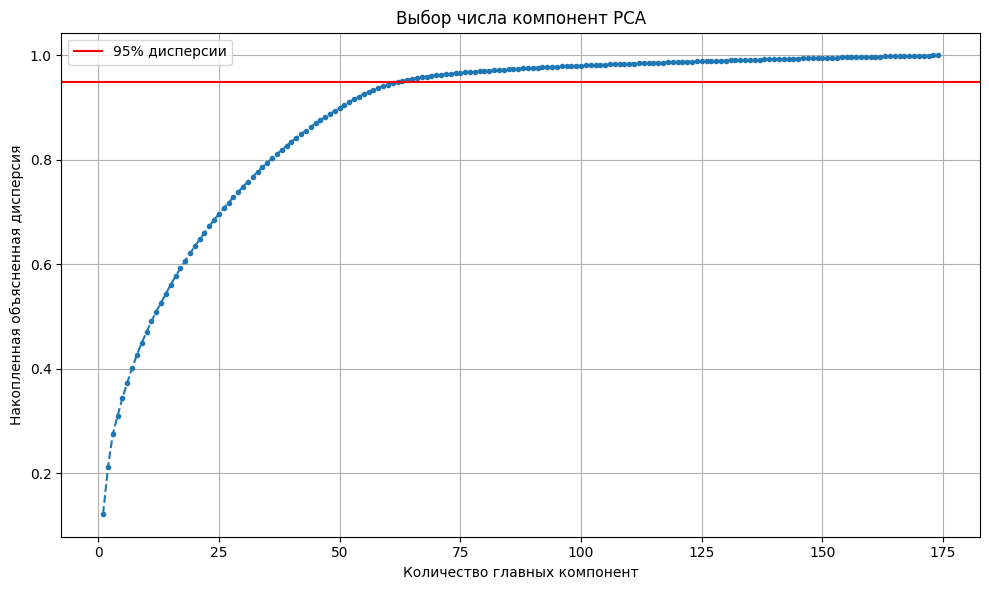

Для 95% дисперсии нужно 63 компонент


In [11]:
pca = PCA()
pca.fit(data)

cumulative_var = np.cumsum(pca.explained_variance_ratio_)

# График объясненной дисперсии
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_),
         marker='.', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-', label='95% дисперсии')

plt.xlabel('Количество главных компонент')
plt.ylabel('Накопленная объясненная дисперсия')
plt.title('Выбор числа компонент PCA')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

target_variance = 0.95  # иногда считается, что понижение размерности должно объяснять 95% дисперсии
optimal_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= target_variance) + 1
print(f"Для {target_variance:.0%} дисперсии нужно {optimal_components} компонент")

### ⚠️ Проблема: «Проклятие размерности»
- **Проклятие размерности:** в 63D пространстве кластеризация работает хуже
- **Шум:** последние компоненты несут очень мало полезной информации
- **Вычисления:** K-means и hierarchical clustering будут медленными

In [12]:
print("Детальный анализ:")
print(f"5 компонент: {cumulative_var[4]:.1%}")
print(f"10 компонент: {cumulative_var[9]:.1%}")
print(f"15 компонент: {cumulative_var[14]:.1%}")
print(f"20 компонент: {cumulative_var[19]:.1%}")
print(f"25 компонент: {cumulative_var[24]:.1%}")
print(f"30 компонент: {cumulative_var[29]:.1%}")
print(f"36 компонент: {cumulative_var[35]:.1%}")

Детальный анализ:
5 компонент: 34.4%
10 компонент: 47.1%
15 компонент: 56.1%
20 компонент: 63.5%
25 компонент: 69.7%
30 компонент: 74.9%
36 компонент: 80.3%


In [13]:
target_variance = 0.60  # возьмем за ориентир 60%
optimal_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= target_variance) + 1
print(f"Для {target_variance:.0%} дисперсии нужно {optimal_components} компонент")

Для 60% дисперсии нужно 18 компонент


In [14]:
pca = PCA(n_components=18)
data_pca = pca.fit_transform(data)

print(f"Данные для кластеризации: {data_pca.shape}")
print(f"Объясненная дисперсия: {np.sum(pca.explained_variance_ratio_):.1%}")

Данные для кластеризации: (174, 18)
Объясненная дисперсия: 60.7%


## 🎯 Алгоритм K-means: один из наиболее популярных методов кластеризации

### 🔍 Основная идея:
**Итеративное повторение двух ключевых шагов:**

#### **1. 📊 Распределение объектов**
- Каждый объект выборки относится к ближайшему центру кластера
- Образуются временные группы объектов

#### **2. 🎯 Пересчет центроидов**
- Центры кластеров обновляются как среднее арифметическое векторов признаков
- Новые позиции = центры масс соответствующих кластеров

В данном методе K - количестов кластеров является гиперпараметром. С точки зрения нашей задачи логичным выбором было бы взять K=9, но давайте построим дополнительные зависимости для исследования этого вопроса

## Метрики качества кластеризации: Inertia, Silhouette Score

### Инерция (Inertia)
**Определение:** Сумма квадратов расстояний от точек до центров их кластеров  

$$Inertia = \sum\limits_{i=1}^k\sum\limits_{x\in C_i} ||x-\mu_i||^2$$
где `k` - число кластеров, `Cᵢ` - i-й кластер, `μᵢ` - его центроид

- **Чем меньше** - тем компактнее кластеры
- **Недостаток:** Уменьшается с ростом `k` (риск переобучения)
- **Применение:** Метод "локтя" для выбора оптимального `k`: ищем "изгиб" (локоть) на графике зависимости инерции от количества кластеров — точку, после которой уменьшение inertia замедляется - эта точка предполагает оптимальное число кластеров
 - **Метод локтя** предполагает сферические кластеры, да и в целом Inertia хорошо работает, когда кластеры сферические и примерно одинакового размера. Для вытянутых или сложной формы кластеров может давать неверные результаты

### Коэффициент силуэта (Silhouette Score)  
**Определение:** Мера соответствия точки своему кластеру vs соседним  
$$S(x_i) = \frac{b(x_i) - a(x_i))}{max(a(x_i), b(x_i))}$$
где `aᵢ` - среднее расстояние до точек своего кластера, `bᵢ` - до ближайшего чужого

**Интерпретация:**
- **+1:** Идеальное разделение кластеров  
- **0:** Точка на границе между кластерами
- **-1:** Точка назначена неверному кластеру

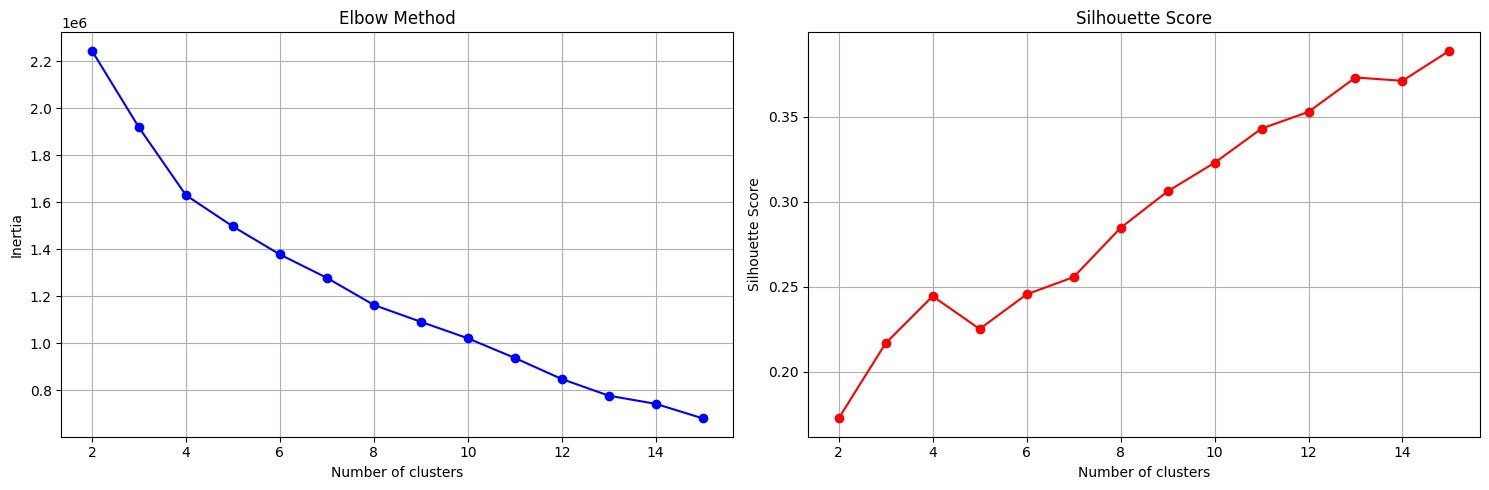

In [15]:
inertias = []
silhouette_scores = []
K_range = range(2, 16)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data_pca)
    inertias.append(kmeans.inertia_)

    if k > 1:  silhouette_scores.append(silhouette_score(data_pca, kmeans.labels_))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')
ax1.grid(True)

ax2.plot(range(2, 16), silhouette_scores, 'ro-')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score')
ax2.grid(True)

plt.tight_layout()
plt.show()

**Результат:**
Определение число кластеров методом локтя показало K = 4. Также стоит отметить, что при этом значении имеется локальный пик коэффициента силуэта

Для n_clusters = 2, средний силуэтный коэффициент: 0.1746
Для n_clusters = 5, средний силуэтный коэффициент: 0.2251
Для n_clusters = 8, средний силуэтный коэффициент: 0.2691
Для n_clusters = 11, средний силуэтный коэффициент: 0.3172
Для n_clusters = 14, средний силуэтный коэффициент: 0.3756


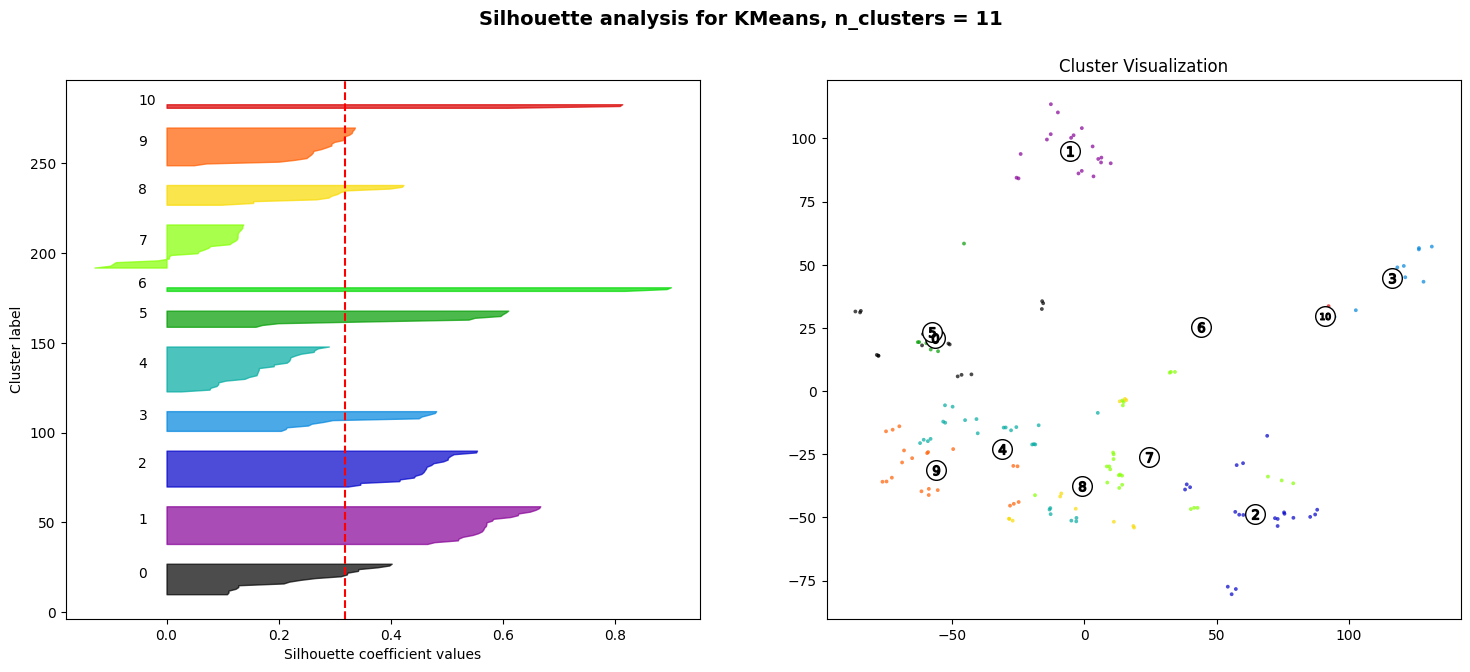

In [16]:
def plot_silhouette_analysis(X, range_clusters):
    for n_clusters in range_clusters:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = clusterer.fit_predict(X)

        silhouette_avg = silhouette_score(X, cluster_labels)
        print(f"Для n_clusters = {n_clusters}, средний силуэтный коэффициент: {silhouette_avg:.4f}")

        # Детальный анализ по точкам
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        ax1.set_xlabel('Silhouette coefficient values')
        ax1.set_ylabel('Cluster label')
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        # Визуализация кластеров
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                   c=colors, edgecolor='k')

        centers = clusterer.cluster_centers_
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                   c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                       s=50, edgecolor='k')

        ax2.set_title('Cluster Visualization')
        plt.suptitle(f'Silhouette analysis for KMeans, n_clusters = {n_clusters}',
                    fontsize=14, fontweight='bold')

    plt.show()

plot_silhouette_analysis(data_pca, K_range[::3])

То есть у нас **3 варианта** развития событий:
 - K = 4, исходя из метода локтя
 - K = 9, исходя из нашего знания о количестве типов рака в датасете
 - K = 15, исходя из коэффициент силуэта

## Метрики, метрики, метрики...

### ARI (Adjusted Rand Index)
Скорректированный индекс Rand, измеряет схожесть двух кластеризаций с поправкой на случайность.

$$ARI = \frac{RI - Expected\_RI}{\max(RI) - Expected\_RI}$$

где $$RI = \frac{a + b}{C(n,2)}$$,
$a$ - пары в одном кластере в обеих кластеризациях,
$b$ - пары в разных кластерах в обеих кластеризациях.

### AMI (Adjusted Mutual Information)
Скорректированная взаимная информация, измеряет согласованность кластеризаций с поправкой на случайность.

$$AMI = \frac{MI - E[MI]}{\text{mean}(H(U), H(V)) - E[MI]}$$

где $MI$ - взаимная информация, $H$ - энтропия.

### Homogeneity (Однородность)
Каждый кластер содержит только объекты одного класса.

$$Homogeneity = 1 - \frac{H(C|K)}{H(C)}$$

где $H(C|K)$ - условная энтропия классов при заданных кластерах.

### Completeness (Полнота)
Все объекты одного класса находятся в одном кластере.

$$Completeness = 1 - \frac{H(K|C)}{H(K)}$$

где $H(K|C)$ - условная энтропия кластеров при заданных классах.

### V-Measure
Гармоническое среднее между Homogeneity и Completeness.

$$V = 2 \cdot \frac{\text{homogeneity} \cdot \text{completeness}}{\text{homogeneity} + \text{completeness}}$$

### FMI (Fowlkes-Mallows Index)
Геометрическое среднее precision и recall для пар объектов.

$$FMI = \frac{TP}{\sqrt{(TP + FP) \cdot (TP + FN)}}$$

где $TP$ - пары в одном кластере в обеих разбиениях, $FP/FN$ - несовпадающие пары.

In [17]:
def evaluate_clustering_with_labels_kmeans(X, true_labels, k_values):
    results = []

    for k in k_values:

        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        pred_labels = kmeans.fit_predict(X)

        metrics = {
            'n_clusters': k,
            'ARI': adjusted_rand_score(true_labels, pred_labels),
            'AMI': adjusted_mutual_info_score(true_labels, pred_labels),
            'Homogeneity': homogeneity_score(true_labels, pred_labels),
            'Completeness': completeness_score(true_labels, pred_labels),
            'V_Measure': v_measure_score(true_labels, pred_labels),
            'FMI': fowlkes_mallows_score(true_labels, pred_labels),
            'Inertia': kmeans.inertia_,
            'Silhouette': silhouette_score(X, pred_labels) if len(np.unique(pred_labels)) > 1 else -1
        }

        results.append(metrics)

    return pd.DataFrame(results)

k_options = [4, 9, 15]
results_df = evaluate_clustering_with_labels_kmeans(data_pca, labels['cancer_type'], k_options)

print("Сравнение кластеризации:")
print(results_df.round(4))

Сравнение кластеризации:
   n_clusters     ARI     AMI  Homogeneity  Completeness  V_Measure     FMI  \
0           4  0.2937  0.5337       0.4367        0.7606     0.5548  0.4683   
1           9  0.5372  0.7114       0.7015        0.7818     0.7395  0.6081   
2          15  0.5482  0.7008       0.8025        0.6980     0.7466  0.5984   

        Inertia  Silhouette  
0  1.629979e+06      0.2444  
1  1.090558e+06      0.3061  
2  6.793865e+05      0.3890  


In [18]:
kmeans4 = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans4_labels = kmeans4.fit_predict(data_pca)
print("K-Means (К = 4) кластеризация завершена")
print(f"Размер кластеров: {np.bincount(kmeans4_labels)}")

kmeans9 = KMeans(n_clusters=9, random_state=42, n_init=10)
kmeans9_labels = kmeans9.fit_predict(data_pca)
print("K-Means (К = 9) кластеризация завершена")
print(f"Размер кластеров: {np.bincount(kmeans9_labels)}")

kmeans15 = KMeans(n_clusters=15, random_state=42, n_init=10)
kmeans15_labels = kmeans15.fit_predict(data_pca)
print("K-Means (К = 15) кластеризация завершена")
print(f"Размер кластеров: {np.bincount(kmeans15_labels)}")

K-Means (К = 4) кластеризация завершена
Размер кластеров: [70 22 64 18]
K-Means (К = 9) кластеризация завершена
Размер кластеров: [43 21 22 28 12  3 36  3  6]
K-Means (К = 15) кластеризация завершена
Размер кластеров: [ 9  8 22  6 20 32  3  6  9 17  9  3  6  3 21]


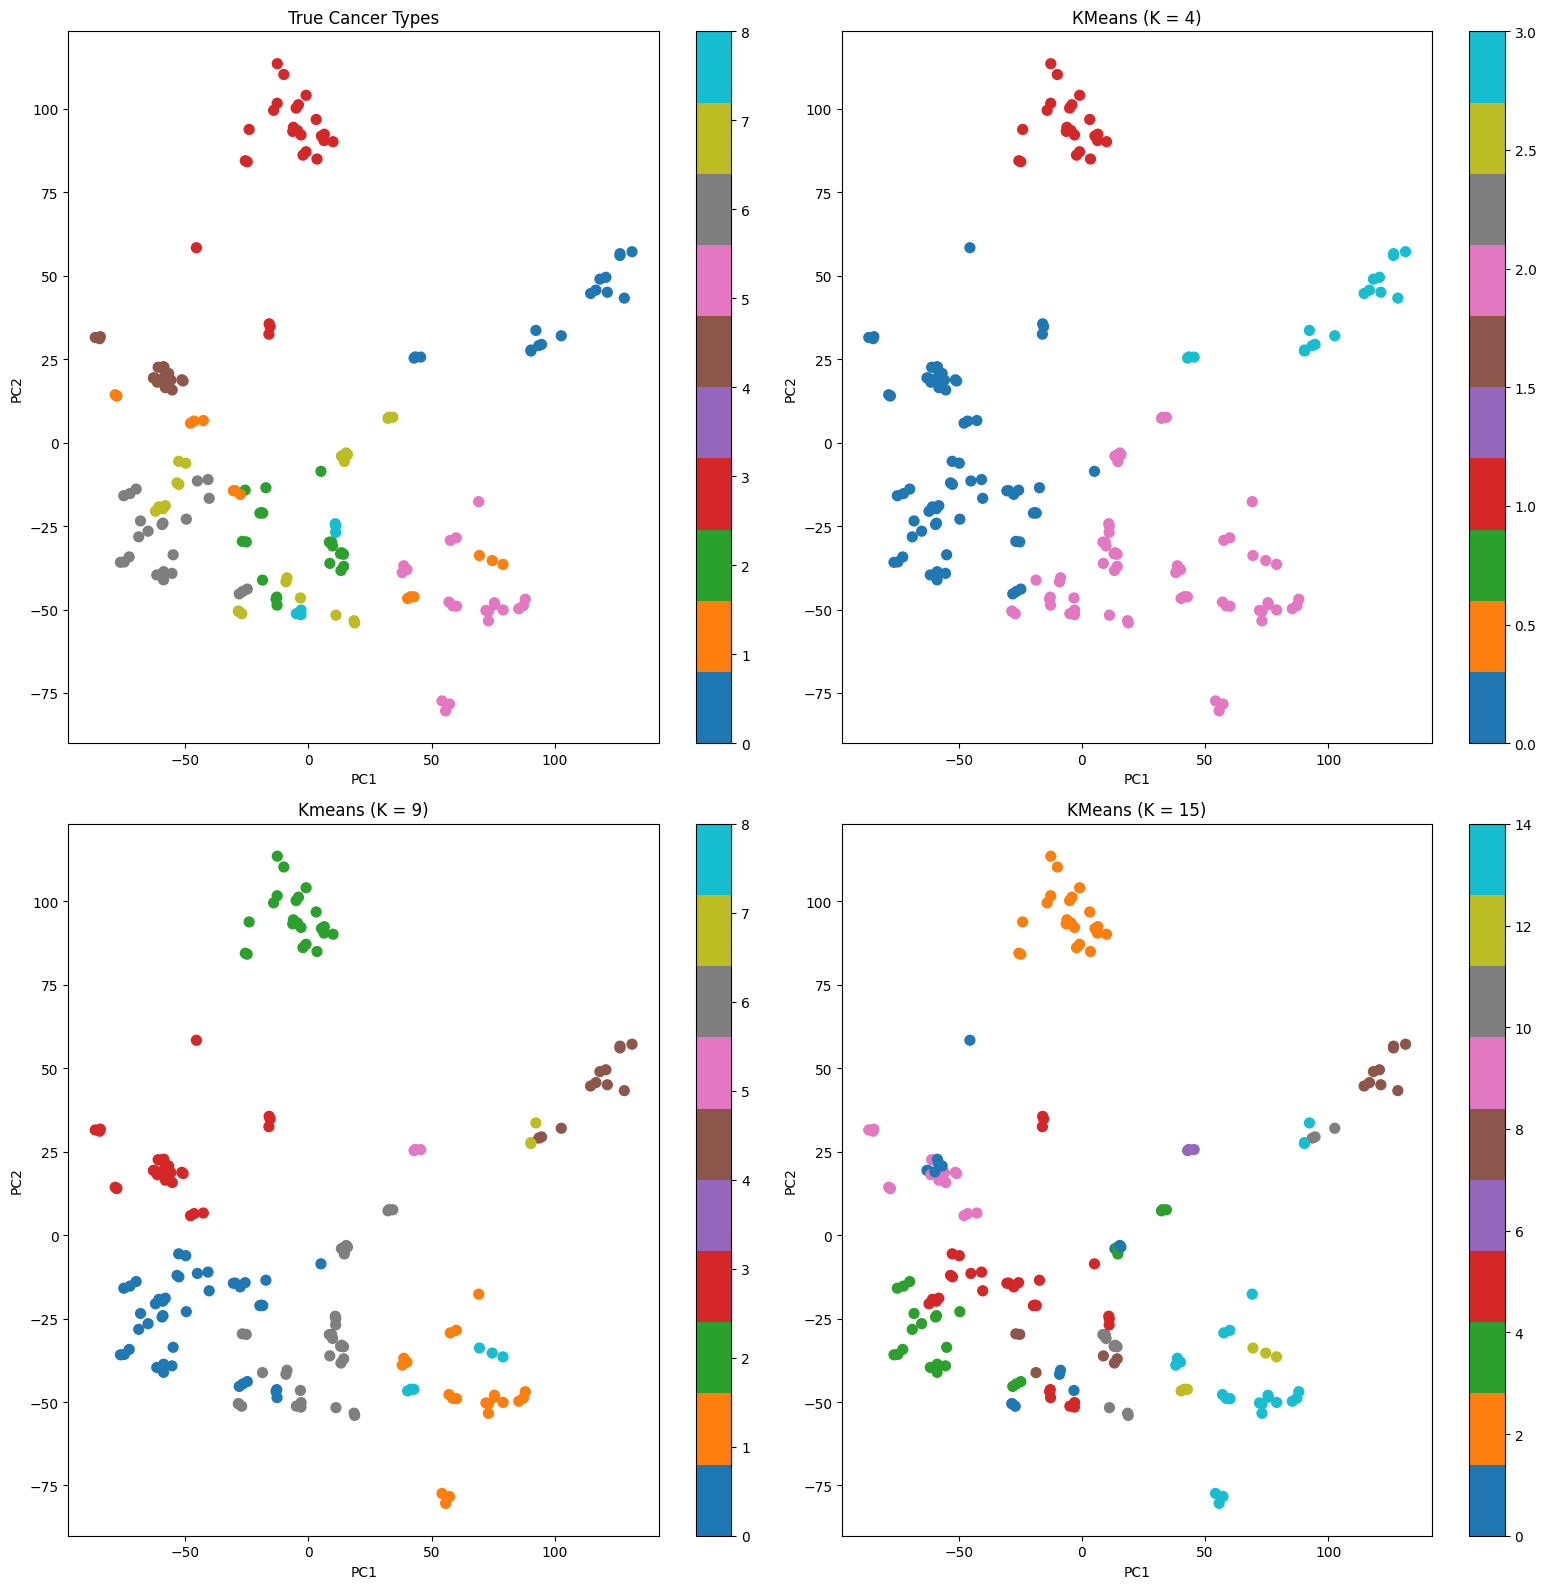

In [19]:
# PCA визуализация с кластерами K-Means
fig, ax = plt.subplots(2, 2, figsize=(16, 16))

# Истинные метки
scatter1 = ax[0, 0].scatter(data_pca[:, 0], data_pca[:, 1],
                      c=pd.factorize(labels['cancer_type'])[0], cmap='tab10', s=50)
ax[0, 0].set_xlabel('PC1')
ax[0, 0].set_ylabel('PC2')
ax[0, 0].set_title('True Cancer Types')
plt.colorbar(scatter1, ax=ax[0, 0])

# K-Means кластеры
scatter2 = ax[0, 1].scatter(data_pca[:, 0], data_pca[:, 1],
                      c=kmeans4_labels, cmap='tab10', s=50)
ax[0, 1].set_xlabel('PC1')
ax[0, 1].set_ylabel('PC2')
ax[0, 1].set_title('КMeans (K = 4)')
plt.colorbar(scatter2, ax=ax[0, 1])

scatter3 = ax[1, 0].scatter(data_pca[:, 0], data_pca[:, 1],
                      c=kmeans9_labels, cmap='tab10', s=50)
ax[1, 0].set_xlabel('PC1')
ax[1, 0].set_ylabel('PC2')
ax[1, 0].set_title('Kmeans (K = 9)')
plt.colorbar(scatter3, ax=ax[1, 0])

scatter4 = ax[1, 1].scatter(data_pca[:, 0], data_pca[:, 1],
                      c=kmeans15_labels, cmap='tab10', s=50)
ax[1, 1].set_xlabel('PC1')
ax[1, 1].set_ylabel('PC2')
ax[1, 1].set_title('KMeans (K = 15)')
plt.colorbar(scatter4, ax=ax[1, 1])

plt.tight_layout()
plt.show()

## Выводы

1. **Проблема выбора K:**
   - **Метод локтя** и **Silhouette Score** указывали на оптимальное число кластеров **K=4**. Это математический оптимум, при котором кластеры максимально плотные и хорошо отделены друг от друга.
   - Однако мы знаем, что истинных типов рака **9**.
   - При **K=4** алгоритм объединяет биологически разные, но молекулярно схожие типы тканей (например, рак груди, легких и яичников часто попадают в один большой кластер).

2. **Анализ при K=9 (True Labels):**
   - Принудительное разбиение на 9 кластеров дает более дробную структуру, которая лучше соответствует биологической истине.
   - Визуально на PCA графике видно, что K=9 "разрезает" крупные облака точек, пытаясь выделить подгруппы.
   - **V-Measure (около 0.7)** показывает, что даже без учителя алгоритм способен неплохо восстановить истинную разметку, хотя некоторые типы рака (например, Non-Small Cell Lung) сложно разделимы из-за высокой вариативности.

3. **Итог:** Математические метрики кластеризации не всегда совпадают с семантикой данных. Для исследовательских целей K=9 или K=15 (локальный пик силуэта) дают больше информации, чем "идеальное" K=4.

## Алгоритм DBSCAN (Density-Based Spatial Clustering)

**Основная идея:** Кластеризация на основе плотности точек в пространстве признаков.

**Гиперпараметры:**
- $\varepsilon$ - радиус окрестности
- $N_0$ - минимальное количество точек для образования кластера

**Типы точек:**
- **Основные (core):** В окрестности $B(\varepsilon, x_i)$ ≥ $N_0$ точек
- **Граничные (border):** В окрестности < $N_0$ точек, но есть основные точки
- **Шумовые (noise):** В окрестности < $N_0$ точек и нет основных точек

**Алгоритм:**
1. Удалить шумовые точки
2. Соединить ребрами основные точки с общими окрестностями
3. Выделить компоненты связности в графе
4. Приписать граничные точки к ближайшим кластерам

**Преимущества:**
- Автоматическое определение количества кластеров
- Устойчивость к шуму
- Обнаружение кластеров произвольной формы
- Работа со сложными структурами (ленты, концентрические сферы)

Попробуем реализовать этот алгоритм

In [20]:
dbscan = DBSCAN(eps=18, min_samples=5)
dbscan_labels = dbscan.fit_predict(data_pca)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Истинные метки
scatter1 = ax1.scatter(data_pca[:, 0], data_pca[:, 1],
                      c=pd.factorize(labels['cancer_type'])[0], cmap='tab10', s=50)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('True Cancer Types')
plt.colorbar(scatter1, ax=ax1)

scatter2 = ax2.scatter(data_pca[:, 0], data_pca[:, 1],
                      c=dbscan_labels, cmap='tab10', s=50)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title('DBSCAN Clustering')
plt.colorbar(scatter2, ax=ax2)

plt.tight_layout()
plt.show()

In [21]:
len(np.unique(dbscan_labels))

1

Oh noooo...

---

Попробуем поперебирать по сетке

In [22]:
def evaluate_clustering_with_labels_dbscan(X, true_labels, eps_val, min_samples_val):

    dbscan = DBSCAN(eps=eps_val, min_samples=int(min_samples_val))
    pred_labels = dbscan.fit_predict(X)

    n_samples = X.shape[0]
    unique_pred_labels = np.unique(pred_labels)
    n_clusters = len(unique_pred_labels) - (1 if -1 in unique_pred_labels else 0)

    # Проверка на валидность для метрик
    # Если кластеров слишком много или только 1 кластер, возвращаем None
    if len(unique_pred_labels) > n_samples - 1 or n_clusters < 2:
        return None

    metrics = {
        'eps': eps_val,
        'min_samples': min_samples_val,
        'n_clusters': n_clusters,
        'ARI': adjusted_rand_score(true_labels, pred_labels),
        'AMI': adjusted_mutual_info_score(true_labels, pred_labels),
        'Homogeneity': homogeneity_score(true_labels, pred_labels),
        'Completeness': completeness_score(true_labels, pred_labels),
        'V_Measure': v_measure_score(true_labels, pred_labels),
        'FMI': fowlkes_mallows_score(true_labels, pred_labels),
        'Silhouette': silhouette_score(X, pred_labels)
    }

    return metrics

In [23]:
eps_array = np.arange(1, 21, 1)
min_sample_array = np.arange(1, 20, 1)

results_list = []

for i in eps_array:
    for j in min_sample_array:
        current_metrics_dict = evaluate_clustering_with_labels_dbscan(
            data_pca,
            labels['cancer_type'],
            eps_val=i,
            min_samples_val=j
        )

        # Если функция вернула словарь (а не None), добавляем его в список
        if current_metrics_dict is not None:
            results_list.append(current_metrics_dict)

dbscan_table = pd.DataFrame(results_list)
dbscan_table

eps  min_samples  n_clusters       ARI       AMI  Homogeneity  \
0     3            1         173  0.001010  0.004659     1.000000   
1     4            1         169  0.005042  0.023110     1.000000   
2     4            2           5  0.008196  0.042640     0.064325   
3     5            1         166  0.008057  0.036755     1.000000   
4     5            2           8  0.013619  0.065411     0.102626   
5     6            1         158  0.016057  0.072356     1.000000   
6     6            2          16  0.027910  0.124748     0.207831   
7     7            1         148  0.025980  0.115313     1.000000   
8     7            2          26  0.021594  0.148065     0.313372   
9     8            1         145  0.028940  0.127880     1.000000   
10    8            2          29  0.015830  0.151391     0.342963   
11    9            1         142  0.031892  0.140303     1.000000   
12    9            2          32  0.012120  0.156554     0.373853   
13   10            1         138  0.035817  0.156647     1.000000   
14   10            2          36  0.030798  0.190378     0.434149   
15   11            1         132  0.041678  0.180707     1.000000   
16   11            2          42  0.025834  0.199214     0.496056   
17   12            1         130  0.043625  0.188607     1.000000   
18   12            2          44  0.023171  0.201529     0.516243   
19   13            1         127  0.046540  0.200348     1.000000   
20   13            2          47  0.025806  0.209507     0.549909   
21   14            1         125  0.048478  0.208103     1.000000   
22   14            2          49  0.026230  0.214404     0.572077   
23   15            1         125  0.048478  0.208103     1.000000   
24   15            2          49  0.026230  0.214404     0.572077   
25   16            1         123  0.050414  0.215801     1.000000   
26   16            2          51  0.023495  0.216561     0.592155   
27   17            1         123  0.050414  0.215801     1.000000   
28   17            2          51  0.023495  0.216561     0.592155   
29   18            1         120  0.053311  0.227242     1.000000   
30   18            2          54  0.024129  0.222949     0.624683   
31   19            1         120  0.053311  0.227242     1.000000   
32   19            2          54  0.024129  0.222949     0.624683   
33   20            1         120  0.053311  0.227242     1.000000   
34   20            2          54  0.024129  0.222949     0.624683   

    Completeness  V_Measure       FMI  Silhouette  
0       0.415986   0.587556  0.023911    0.010902  
1       0.418575   0.590135  0.053468    0.052642  
2       0.441141   0.112278  0.331479   -0.171047  
3       0.420539   0.592084  0.067632    0.083059  
4       0.441355   0.166529  0.326031   -0.149279  
5       0.425866   0.597344  0.095646    0.163119  
6       0.451123   0.284564  0.309713   -0.118032  
7       0.432718   0.604052  0.121925    0.261078  
8       0.424034   0.360400  0.261441   -0.097832  
9       0.434817   0.606094  0.128767    0.289366  
10      0.417803   0.376702  0.243358   -0.066405  
11      0.436936   0.608149  0.135263    0.315374  
12      0.414525   0.393140  0.227614   -0.033593  
13      0.439794   0.610912  0.143468    0.349471  
14      0.430480   0.432307  0.229417    0.022924  
15      0.444152   0.615104  0.154964    0.399589  
16      0.425695   0.458190  0.200339    0.102643  
17      0.445623   0.616514  0.158610    0.415488  
18      0.424330   0.465796  0.189893    0.133446  
19      0.447850   0.618641  0.163928    0.440332  
20      0.425411   0.479714  0.180295    0.179734  
21      0.449346   0.620067  0.167380    0.455029  
22      0.426069   0.488394  0.172755    0.208008  
23      0.449346   0.620067  0.167380    0.455029  
24      0.426069   0.488394  0.172755    0.208008  
25      0.450853   0.621500  0.170762    0.468182  
26      0.425353   0.495082  0.162504    0.229954  
27      0.450853   0.621500  0.170762    0.468182  
28      0.4

**Что можно понять по этой таблице?**
 - DBSCAN не скупится на кластеры, а нам для адекватной оценки хотелось бы что-то по порядку совпадающие с реальным количеством (нахождение какой-то генеральной зависимости или нахождение разных кластеров внутри одного типа рака)
 - На наших данных алгоритм чувствителен к значениям гиперпараметров
 - Показания V-меры и коэффициента силуэта плохи, не везде, но плохи

Попробуем оптимизировать поиск наилучших параметров с помощью библиотеки `hyperopt`

In [24]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

space = {
    'eps': hp.uniform('eps', 15, 85),
    'min_samples': hp.quniform('min_samples', 1, 20, 1)
}

def objective(params):
    eps = params['eps']
    min_samples = int(params['min_samples'])

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels_pred = dbscan.fit_predict(data_pca)

    # Оценка качества кластеризации с помощью V-меры
    n_clusters = len(set(labels_pred)) - (1 if -1 in labels_pred else 0)
    noise_ratio = np.sum(labels_pred == -1) / len(labels_pred)

    # Штрафы за невалидные конфигурации
    if n_clusters < 2:
        return {'loss': float('inf'), 'status': STATUS_OK}

    if noise_ratio > 0.5:
        return {'loss': float('inf'), 'status': STATUS_OK}

    try:
        v_score = v_measure_score(labels['cancer_type'], labels_pred)

        # Hyperopt минимизирует функцию, поэтому мы используем 1 - score
        return {'loss': 1 - v_score, 'status': STATUS_OK}

    except Exception as e:
        return {'loss': float('inf'), 'status': STATUS_OK}

trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

print("Лучшие параметры:", best)

100%|██████████| 100/100 [00:02<00:00, 36.21trial/s, best loss: 0.2432743641284677]
Лучшие параметры: {'eps': 72.71872891173908, 'min_samples': 1.0}


In [25]:
dbscan = DBSCAN(eps=best['eps'], min_samples=int(best['min_samples']))
dbscan_labels = dbscan.fit_predict(data_pca)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Истинные метки
scatter1 = ax1.scatter(data_pca[:, 0], data_pca[:, 1],
                      c=pd.factorize(labels['cancer_type'])[0], cmap='tab10', s=50)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('True Cancer Types')
plt.colorbar(scatter1, ax=ax1)

scatter2 = ax2.scatter(data_pca[:, 0], data_pca[:, 1],
                      c=dbscan_labels, cmap='tab10', s=50)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title('DBSCAN Clustering')
plt.colorbar(scatter2, ax=ax2)

plt.tight_layout()
plt.show()

In [26]:
results_df_dbscan = evaluate_clustering_with_labels_dbscan(data_pca, labels['cancer_type'], best['eps'], best['min_samples'])
pd.DataFrame([results_df_dbscan])

eps  min_samples  n_clusters       ARI       AMI  Homogeneity  \
0  72.718729          1.0          25  0.499333  0.686704      0.88132   

   Completeness  V_Measure      FMI  Silhouette  
0      0.662996   0.756726  0.55718    0.456116

## Выводы:

1. **Сложность настройки:**
   - DBSCAN оказался **наименее устойчивым** методом для данного датасета.
   - Алгоритм либо определял всё как "шум", либо сливал данные в один гигантский кластер. Ручной подбор параметров по сетке дал слабые результаты.

2. **Результаты оптимизации (Hyperopt):**
   - Даже с автоматическим подбором гиперпараметров (`eps` ≈ 72, `min_samples` = 1), алгоритм выделил **25 кластеров**, что  превышает истинное количество классов (9).
   - **Homogeneity (0.88)** высокая: это значит, что найденные мелкие кластеры "чистые" (состоят из одного типа рака).
   - **Completeness (0.66)** низкая: алгоритм "раздробил" истинные классы на множество мелких групп и не смог собрать их воедино.

3. **Почему так вышло?**
   - Плотность данных в пространстве PCA неравномерна. DBSCAN ищет регионы с *постоянной* высокой плотностью.
   - Клеточные линии одного типа рака могут иметь разброс в экспрессии генов (разную плотность), из-за чего DBSCAN воспринимает их как разные кластеры или шум.
   - **Итог:** Для задач с фиксированным ожидаемым количеством классов и разной плотностью кластеров DBSCAN подходит хуже, чем K-Means.

## Иерархическая кластеризация

**Основная идея:** Построение древовидной структуры (дендрограммы) кластеров через последовательное объединение или разделение объектов.

**Подходы:**
- **Агломеративный (восходящий):** Начинается с отдельных точек, последовательно объединяет ближайшие кластеры
- **Дивизивный (нисходящий):** Начинается с одного кластера, последовательно разделяет на более мелкие

**Методы объединения кластеров:**
- **Single Link:** Минимальное расстояние между объектами кластеров
- **Complete Link:** Максимальное расстояние между объектами кластеров  
- **Average Link:** Среднее расстояние между объектами кластеров
- **Ward's Method:** Минимизация дисперсии при объединении

**Математическая основа:**
Расстояние между кластерами $C_i$ и $C_j$ вычисляется как:
$$d(C_i, C_j) = f(d(x, y)) \quad \forall x \in C_i, y \in C_j$$

**Результат:** Дендрограмма - дерево, показывающее последовательность объединения кластеров и расстояния на каждом шаге.

**Преимущества:**
- Визуальная интерпретируемость (дендрограмма)
- Не требует задания числа кластеров заранее
- Чувствительность к форме кластеров

**Недостатки:**
- Высокая вычислительная сложность $O(n^3)$
- Чувствительность к выбросам
- Необратимость объединений

In [27]:
def visualize_dendrogram(data, method='ward', metric='euclidean', title="Dendrogram"):
    """
    Вычисляет и визуализирует дендрограмму для иерархической кластеризации.

    Args:
        data (np.array): Входные данные.
        method (str): Метод соединения (linkage): 'ward', 'complete', 'average', 'single'.
        metric (str): Метрика расстояния, например, 'euclidean'.
        title (str): Заголовок графика.
    """
    # Вычисление матрицы связей
    Z = linkage(data, method=method, metric=metric)

    plt.figure(figsize=(12, 7))
    plt.title(title + f" (Linkage: {method})")
    plt.xlabel('Sample index or Cluster size')
    plt.ylabel('Distance')

    # Построение дендрограммы
    dendrogram(
        Z,
        leaf_rotation=90.,
        leaf_font_size=8.,
        truncate_mode='lastp',
        p=30
    )
    plt.show()

    return Z


def compare_linkages(data, true_labels=None, n_clusters_manual=4):
    """
    Сравнивает различные методы соединения (linkage methods)
    и визуализирует их дендрограммы, а также оценивает качество (если есть true_labels).

    Args:
        data (np.array): Входные данные.
        true_labels (np.array, optional): Истинные метки классов для оценки V-меры.
        n_clusters_manual (int): Предполагаемое количество кластеров для разрезания дендрограммы.
    """
    methods = ['ward', 'complete', 'average', 'single']
    results = {}

    for i, method in enumerate(methods):

        Z = linkage(data, method=method, metric='euclidean')

        # Оценка качества (если есть истинные метки)
        if true_labels is not None:

            predicted_labels_arr = cut_tree(Z, n_clusters=n_clusters_manual).flatten()

            try:
                v_score = v_measure_score(true_labels, predicted_labels_arr)

                if len(set(predicted_labels_arr)) > 1:
                    silhouette_avg = silhouette_score(data, predicted_labels_arr)
                else:
                    silhouette_avg = np.nan

                results[method] = {'V-Measure': v_score, 'Silhouette Score': silhouette_avg}
            except ValueError:
                results[method] = {'V-Measure': np.nan, 'Silhouette Score': np.nan}

    if true_labels is not None:
        return pd.DataFrame(results).T

In [28]:
z = visualize_dendrogram(data_pca, method='ward')

In [29]:
print('=' * 40)
for i in [4, 9, 15]:
    comparison_df = compare_linkages(data_pca, true_labels=labels['cancer_type'], n_clusters_manual=i)
    print(f'Linkage comparison: n_clusters = {i}')
    print(comparison_df)
    print('=' * 40)

Linkage comparison: n_clusters = 4
          V-Measure  Silhouette Score
ward       0.601812          0.238112
complete   0.434690          0.184166
average    0.259320          0.299969
single     0.259320          0.299969
Linkage comparison: n_clusters = 9
          V-Measure  Silhouette Score
ward       0.749854          0.314155
complete   0.588463          0.284011
average    0.599260          0.304614
single     0.378210          0.152244
Linkage comparison: n_clusters = 15
          V-Measure  Silhouette Score
ward       0.744794          0.401801
complete   0.753891          0.399446
average    0.763001          0.410432
single     0.666914          0.294488


По выведенной таблице понимаем, что:
 - для количеств кластеров 4 и 9 лучше всего подходит `ward-linkage`
 - для количества кластеров 15 лучше всего подходит `average-linkage`

In [30]:
Z = linkage(data_pca, method='ward', metric='euclidean')
h4_pred = cut_tree(Z, n_clusters=4).flatten()
h9_pred = cut_tree(Z, n_clusters=9).flatten()

Z = linkage(data_pca, method='average', metric='euclidean')
h15_pred = cut_tree(Z, n_clusters=15).flatten()

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16))

# Истинные метки
scatter1 = ax[0, 0].scatter(data_pca[:, 0], data_pca[:, 1],
                      c=pd.factorize(labels['cancer_type'])[0], cmap='tab10', s=50)
ax[0, 0].set_xlabel('PC1')
ax[0, 0].set_ylabel('PC2')
ax[0, 0].set_title('True Cancer Types')
plt.colorbar(scatter1, ax=ax[0, 0])

scatter2 = ax[0, 1].scatter(data_pca[:, 0], data_pca[:, 1],
                      c=h4_pred, cmap='tab10', s=50)
ax[0, 1].set_xlabel('PC1')
ax[0, 1].set_ylabel('PC2')
ax[0, 1].set_title('Hierarchical Clustering (n_clusters = 4)')
plt.colorbar(scatter2, ax=ax[0, 1])

scatter3 = ax[1, 0].scatter(data_pca[:, 0], data_pca[:, 1],
                      c=h9_pred, cmap='tab10', s=50)
ax[1, 0].set_xlabel('PC1')
ax[1, 0].set_ylabel('PC2')
ax[1, 0].set_title('Hierarchical Clustering (n_clusters = 9)')
plt.colorbar(scatter3, ax=ax[1, 0])

scatter4 = ax[1, 1].scatter(data_pca[:, 0], data_pca[:, 1],
                      c=h15_pred, cmap='tab10', s=50)
ax[1, 1].set_xlabel('PC1')
ax[1, 1].set_ylabel('PC2')
ax[1, 1].set_title('Hierarchical Clustering (n_clusters = 15)')
plt.colorbar(scatter4, ax=ax[1, 1])

plt.tight_layout()
plt.show()

## Выводы:

### Сравнение методов иерархической кластеризации
1. **Метод Уорда (Ward Linkage):**
   - Показал **наилучшие результаты** для K=4 и K=9.
   - Метрика **V-Measure (~0.76)** при K=9 сравнима или даже превосходит результаты K-Means.
   - Этот метод минимизирует дисперсию внутри кластеров, что хорошо работает на компактных группах клеточных линий.

2. **Average и Complete Linkage:**
   - Показали результаты хуже, чем Ward, особенно при малом числе кластеров.
   - Однако при сильном дроблении (K=15) метод Average показал неплохую устойчивость.

### Общее резюме проекта
Мы провели снижение размерности (PCA) и протестировали три подхода к кластеризации генной экспрессии NCI-60:

| Алгоритм | Оценка качества | Примечание |
|----------|-----------------|------------|
| **K-Means** | ⭐⭐⭐⭐ | Хорошо работает при K=9, но требует заранее знать число кластеров. Метод локтя вводит в заблуждение (предлагает K=4). |
| **DBSCAN** | ⭐⭐ | Плохо справляется из-за разной плотности кластеров. Сильно дробит данные (30+ кластеров). |
| **Agglomerative (Ward)** | ⭐⭐⭐⭐⭐ | **Победитель.** Дает отличную метрику V-Measure (0.76), позволяет гибко выбирать уровень отсечения (дендрограмма) и хорошо интерпретируется. |

**Биологический смысл:**
Анализ показал, что экспрессия генов действительно позволяет сгруппировать клеточные линии по типу ткани происхождения с точностью около 75-80%. Оставшиеся 20% ошибок могут быть связаны с тем, что некоторые раковые клетки теряют специфичность ткани или мутируют схожим образом (например, меланома и некоторые виды рака легких).